#### Companion notebook for Mel Spectrogram 2D CNN without data augmentation

In this notebook the following procedures are done:
- Using Mel Spectrograms without data augmentation
- Training a 2D CNN and testing (here I mean validation, sorry for using them in opposite)
- Plotting evaluation metrics
- Visualizing feature maps from the convolutional layers
  

**FYI**: <br>
To use:
- random subsampling
- k-fold cross validation
- weight resetting to avoid parameter leakage
- Monte Carlo dropout
- terminal/shell training with arguments

Check the training .py files that starts with *train*

In [17]:
import os
os.chdir("data/custom_cough/")

import librosa

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt


import torch.nn as nn
import torch
from torchaudio.transforms import MelSpectrogram
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from utils.helper_functions import training_grounds, testing_grounds, train_pipeline, initialize_weights


#### Building the 2D CNN

In [2]:
class ClassifierBlock(nn.Module):
    def __init__(self, out_features):
        super(ClassifierBlock, self).__init__()
        
        total_input_dim = 8192*2 + 65536
        self.lin1 = nn.Linear(in_features=(total_input_dim), out_features=out_features)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(in_features=128, out_features=1)
        self.sgm = nn.Sigmoid()  # Should not be needed if binary cross entropy loss because it already applies it
        
    def forward(self, x):
       return self.sgm( self.lin2( self.relu( self.lin1( x ) ) ) )

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=2):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        #x = self.conv(x)
        x = self.pool( self.relu( self.conv(x)  ) )
        return x
        
        

class CustomDataset(Dataset):
    
    def __init__(self, mel_path, annotations_file):
        self.mel_path = mel_path
        self.annotations = pd.read_csv(annotations_file)
        
    
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        mel_sample_path = self._get_mel_path(idx)
        label = self._get_mel_sample_label(idx)
        
        mel = torch.load(mel_sample_path).unsqueeze_(0)
        
        return mel, label
        
    
    def _get_mel_path(self, idx):
        
        path = os.path.join(self.mel_path, self.annotations.iloc[idx, 2])
        return path
    
    def _get_mel_sample_label(self, idx):
        return self.annotations.iloc[idx, 1]
        
  
class SingleCNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = ConvBlock(1, 32)
        self.conv2 = ConvBlock(32, 64)
        self.conv3 = ConvBlock(64, 128)
        self.conv4 = ConvBlock(128, 256)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(19200, 1)

    def forward(self, x):
        x = self.flatten( self.conv4( self.conv3( self.conv2( self.conv1( x ) ) ) ) )
        return self.linear(x)

#### Instantiate the dataloaders

In [4]:
trainload = CustomDataset("train", "train/train_labels.csv")
testload = CustomDataset("test", "test/test_labels.csv")

trainer = DataLoader(trainload, batch_size=16)
tester = DataLoader(testload, batch_size=16)

#### Use weight initialization

In [5]:
cnn = SingleCNN2D().to("cuda")
initialize_weights(cnn)

In [6]:
from torchsummary import summary
summary(cnn, input_size=(1,64,219))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 66, 221]             320
              ReLU-2          [-1, 32, 66, 221]               0
         MaxPool2d-3          [-1, 32, 33, 110]               0
         ConvBlock-4          [-1, 32, 33, 110]               0
            Conv2d-5          [-1, 64, 35, 112]          18,496
              ReLU-6          [-1, 64, 35, 112]               0
         MaxPool2d-7           [-1, 64, 17, 56]               0
         ConvBlock-8           [-1, 64, 17, 56]               0
            Conv2d-9          [-1, 128, 19, 58]          73,856
             ReLU-10          [-1, 128, 19, 58]               0
        MaxPool2d-11           [-1, 128, 9, 29]               0
        ConvBlock-12           [-1, 128, 9, 29]               0
           Conv2d-13          [-1, 256, 11, 31]         295,168
             ReLU-14          [-1, 256,

#### We're using BCE with logits because it has the sigmoid built in. That means we don't have to add a sigmoid layer in the model.

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(cnn.parameters(), lr=0.001)

#### Just doing 10 epochs for demonstration. Run the training files instead =)

We don't do any random subsampling and cross validation here (just demonstrating in the notebooks).

In [10]:
results = train_pipeline(model=cnn,
               train_dataloader=trainer,
               test_dataloader=tester,
               optimizer=optim,
               loss_fn=loss_fn,
               epochs=10,
               device="cuda")

Epoch: 0 | Train loss: 162.2631 | Train acc: 0.8339 | Test loss: 6.8758 | Test acc: 0.8748 | Test precision 0.8908 | Test recall 0.8632 | Test F1: 0.8768
Epoch: 1 | Train loss: 3.3363 | Train acc: 0.9029 | Test loss: 8.2275 | Test acc: 0.8800 | Test precision 0.9052 | Test recall 0.8550 | Test F1: 0.8794
Epoch: 2 | Train loss: 1.6943 | Train acc: 0.9243 | Test loss: 3.5333 | Test acc: 0.9083 | Test precision 0.9345 | Test recall 0.8827 | Test F1: 0.9079
Epoch: 3 | Train loss: 0.6533 | Train acc: 0.9350 | Test loss: 5.1598 | Test acc: 0.8872 | Test precision 0.8649 | Test recall 0.9283 | Test F1: 0.8955
Epoch: 4 | Train loss: 0.7325 | Train acc: 0.9407 | Test loss: 3.8981 | Test acc: 0.9095 | Test precision 0.9094 | Test recall 0.9153 | Test F1: 0.9123
Epoch: 5 | Train loss: 0.2557 | Train acc: 0.9489 | Test loss: 3.7631 | Test acc: 0.9065 | Test precision 0.8924 | Test recall 0.9316 | Test F1: 0.9116
Epoch: 6 | Train loss: 0.5498 | Train acc: 0.9471 | Test loss: 8.9347 | Test acc: 0.87

#### Not a good model even though it seems so :(

Take a validation sample (remember I'm using them in opposite to (validation sample -> test sample))

In [37]:
meller = MelSpectrogram(16000, n_fft=1024, hop_length=512, n_mels=64)

sample_y, sr = librosa.load("validation/clearing_throat.wav", sr=16000)
sample_y2, sr = librosa.load("validation/snoring_throat_issue.wav", sr=16000)
sample_y3, sr = librosa.load("validation/joe_rogan_podcast_2038.wav", sr=16000)

sample_mel = meller(torch.tensor(sample_y))
sample_mel = torch.tensor(sample_mel)[None, None,:,:].to("cuda")

sample_mel2 = meller(torch.tensor(sample_y2))
sample_mel2 = torch.tensor(sample_mel2)[None, None,:,:].to("cuda")

sample_mel3 = meller(torch.tensor(sample_y3))
sample_mel3 = torch.tensor(sample_mel3)[None, None,:,:].to("cuda")


#### Model has overfit

In [38]:
print("Prediction sample 'clearing_throat': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(sample_mel))).cpu().detach().numpy()[0][0], 2)))
print("Prediction sample 'snoring_throat_issue': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(sample_mel2))).cpu().detach().numpy()[0][0], 2)))
print("Prediction sample 'joe_rogan_podcast_2038': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(sample_mel3))).cpu().detach().numpy()[0][0], 2)))

Prediction sample 'clearing_throat': Cough 0.91 probability
Prediction sample 'snoring_throat_issue': Cough 1.0 probability
Prediction sample 'joe_rogan_podcast_2038': Cough 1.0 probability


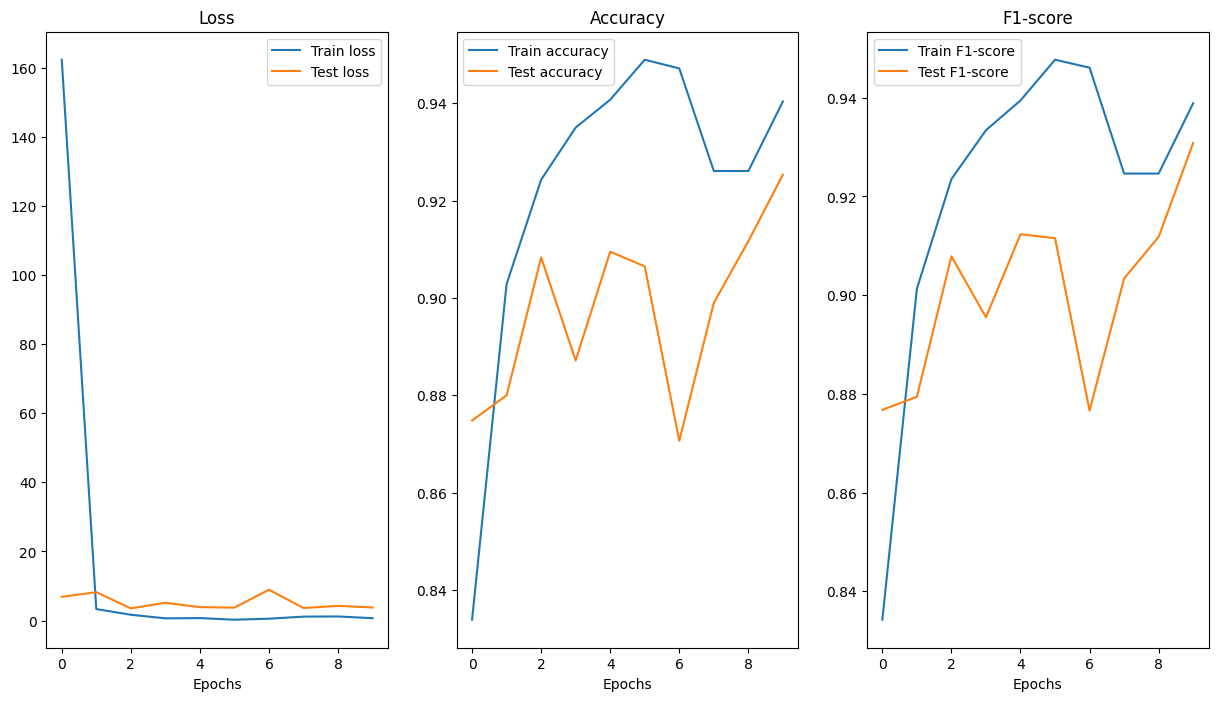

In [30]:
plt.figure(figsize=(15, 8))

plt.subplot(1,3,1)

r = 10

plt.plot(range(r), results["train_loss"], label="Train loss")
plt.plot(range(r), results["test_loss"], label="Test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(r), results["train_acc"], label="Train accuracy")
plt.plot(range(r), results["test_acc"], label="Test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()


plt.subplot(1,3,3)
plt.plot(range(r), results["train_f1"], label="Train F1-score")
plt.plot(range(r), results["test_f1"], label="Test F1-score")
plt.title("F1-score")
plt.xlabel("Epochs")
plt.legend()

#### Let's have a look at the original audio file in the convolutional layers

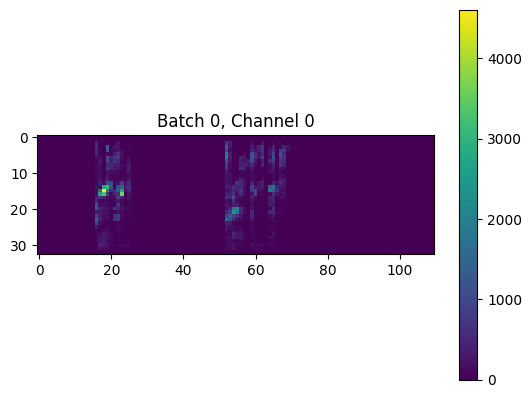

In [33]:
mel_sample = testload.__getitem__(0)[0]

output = cnn.conv1(mel_sample.to("cuda"))

# Loop over the batch dimension
for i in range(1):
    # Loop over the channels
    for j in range(1):
        plt.imshow(output[i].detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f"Batch {i}, Channel {j}")
        plt.show()

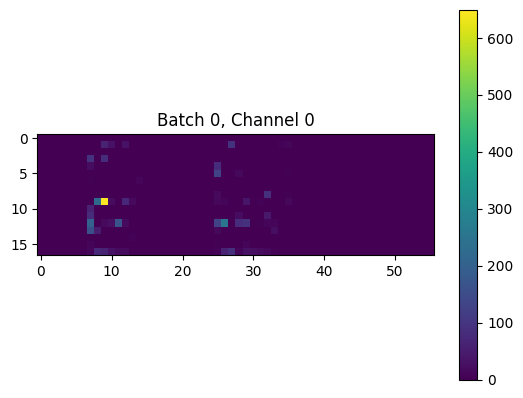

In [34]:
output = cnn.conv2(output)

# Loop over the batch dimension
for i in range(1):
    # Loop over the channels
    for j in range(1):
        plt.imshow(output[i].detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f"Batch {i}, Channel {j}")
        plt.show()

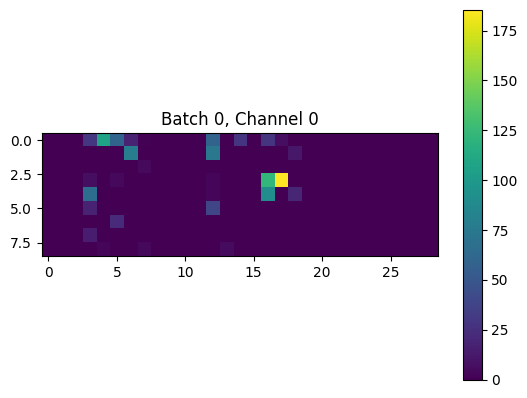

In [35]:
output = cnn.conv3(output)

# Loop over the batch dimension
for i in range(1):
    # Loop over the channels
    for j in range(1):
        plt.imshow(output[i].detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f"Batch {i}, Channel {j}")
        plt.show()

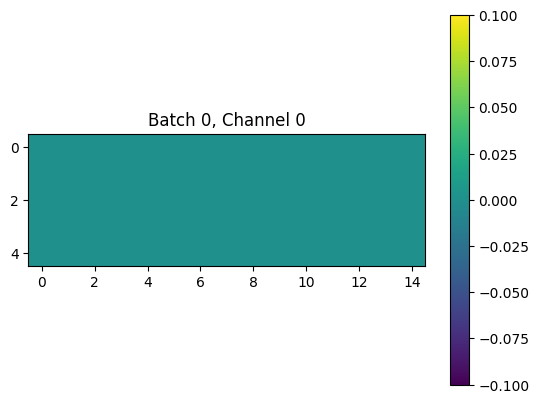

In [36]:
output = cnn.conv4(output)

# Loop over the batch dimension
for i in range(1):
    # Loop over the channels
    for j in range(1):
        plt.imshow(output[i].detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title(f"Batch {i}, Channel {j}")
        plt.show()